# Part 2: Data Modeling with Seasonal ARIMA (SARIMA)

In this part we will model one of the most popular Time-Series Forecasting model SARIMA, which is the subset of ARIMA.<br>

#   &emsp; &emsp;    A R I M A &emsp; ==> &emsp;    AR   &emsp;     &emsp;     +     &emsp;   &emsp;  MA

###                              &emsp;      &emsp;&emsp;&emsp;&emsp;&emsp;  &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;  (Auto Regression)    &emsp;     &emsp;    (Moving Average)
<H3>    &emsp; &emsp;&emsp;       I ==>    Integration </H3>





### Autoregression (AR)
The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.<br>

### Moving Average (MA)
A moving average (rolling average or running average) is a calculation to analyze data points by creating a series of averages of different subsets of the full data set. It is also called a moving mean (MM) or rolling mean and is a type of finite impulse response filter.

### Integration (I)
To make the time series stationary (by removing the Trends) by measuring the differences of observations at different time.


### Why not  ARIMA?
Although, Trends from the data can be removed by ARIMA model. But the series can still have seasonal component. Since, our data may have slight seasonal component So we will use SARIMA instead of ARIMA.
<br>

### SARIMA
<br>
Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.
<br>

***notation: <b>SARIMA(p,d,q)(P,D,Q,S)</b>*** <br><br>
Here (p,d,q) are Trend parameters and (P,D,Q,S) are seasonal parameters. Let's explore these parameters.<br>
<br><b>Trend parameter<br></b>
p: Trend autoregression order.<br>
d: Trend difference order.<br>
q: Trend moving average order.<br>
<br><b>Seasonal Parameter:<br></b>
P: Seasonal autoregressive order.<br>
D: Seasonal difference order.<br>
Q: Seasonal moving average order.<br>
S: The number of time steps for a single seasonal period.


In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Let us first load our created Train-Test datasets. We have two choices. Either we can load daily data or we can load monthly data. Let's first try daily data. Since we have multiple pollutants data, We will work on PM2.5 dataset first.<br><br>
***It's important to note that our train-test datasets contain Date-Time in first column as string. So, its better to parse them first as dates using pandas parse_dates parameter and set the parsed dates as index.***

In [2]:
# load datasets
train_PM25 = pd.read_csv('dataset/daily/train/train_PM2.5.csv', parse_dates = [0], index_col = [0])
test_PM25 = pd.read_csv('dataset/daily/test/test_PM2.5.csv', parse_dates = [0], index_col = [0])

In [18]:
# print first few rows
train_PM25.head()

,PM2.5
Date-Time,
2013-03-01,6.458333
2013-03-02,28.750000
2013-03-03,104.750000
2013-03-04,22.875000
2013-03-05,131.833333


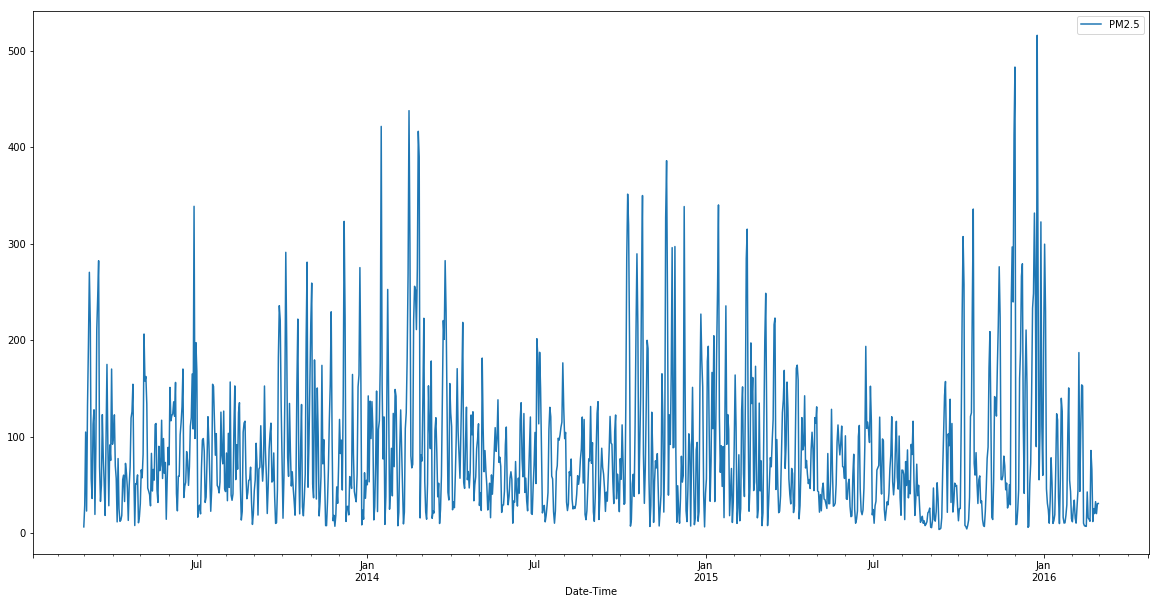

In [19]:
# lets plot our data
train_PM25.plot(figsize = (20,10))

#### Searching for Parameters (p,d,q)(P,D,Q,S) 
In order to best fit SARIMA model into our daily data, we need to find best trend parameters(p, d, q) and Seasonal parameter (P,D,Q,S). Since we have very large daily data, it is not feasible to apply grid search for all possible parameters. So we'll use visual inspection of ACF (Autocorrelation) and PACF(Partial Autocorrelation) plots to find hyper parameters for our SARIMA model. <br>


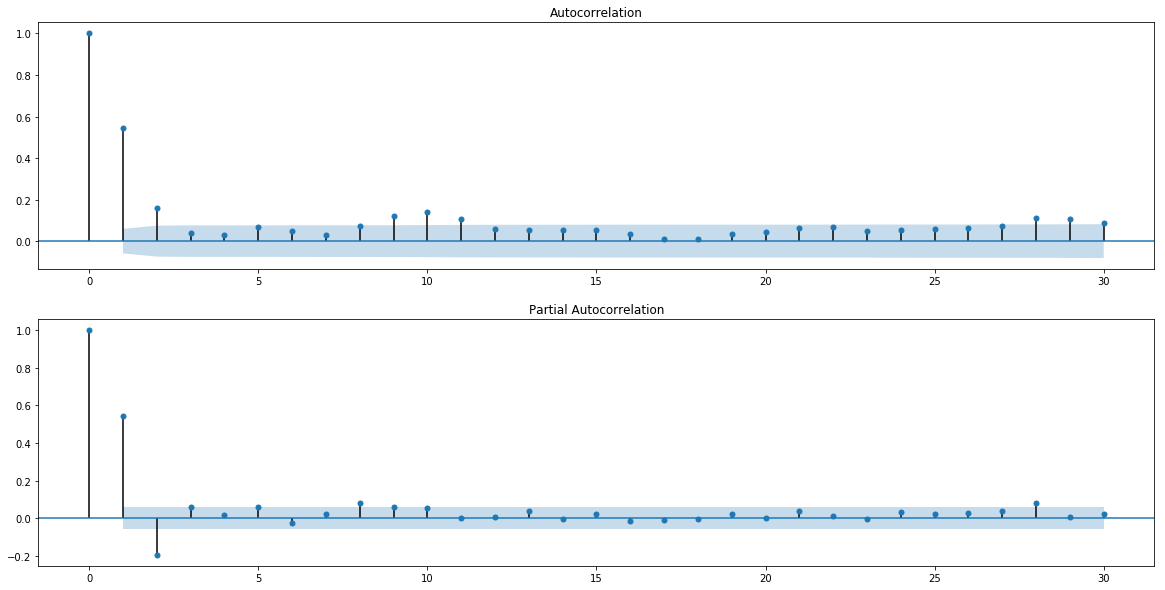

In [23]:
# let us plot acf and pacf graphs
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize = (20,10))
plt.subplot(211)
plot_acf(train_PM25, ax=plt.gca(), lags = 30)
plt.subplot(212)
plot_pacf(train_PM25, ax=plt.gca(), lags = 30)
plt.show()


### Analysing ACF and PACF plots:
We will use Rules for SARIMA model selection from ACF/PACF plots from this site: https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima

#### Rule for identifying d:
<br>
d=0 if the series has no visible trend or ACF at all lags is low.

d≥1 if the series has visible trend or positive ACF values out to a high number of lags.

In our case there is no visible trend and ACF is not low at all lags, So we will take d as 0 and 1.

#### Rule for Identifying the number of AR and MA terms (p and q)
<br>
p is equal to the first lag where the PACF value is above the significance level. So p will be 8.

q is equal to the first lag where the ACF value is above the significance level. So q will be 9.

#### Rule for Identifying the seasonal part of the model:
<br>
S is equal to the ACF lag with the highest value (typically at a high lag), So S may be 10.

D=1 if the series has a stable seasonal pattern over time.

D=0 if the series has an unstable seasonal pattern over time.

Since, In our case there is no stable seasonal pattern visible, So we'll take D = 0

***Rule of thumb: d+D≤2***

P≥1 if the ACF is positive at lag S, else P=0. Since ACF is positive at lag 10, So may take P as 1 or 2

Q≥1 if the ACF is negative at lag S, else Q=0. Since ACF is positive at lag 10, So we'll take Q as 0.

***Rule of thumb: P+Q≤2***

<br>
So, possible values for hyperparameters will be:
<br>
<br>p = 8
<br>d = 0 and 1
<br>q = 9
<br>P = 1 and 2
<br>D = 0
<br>Q = 0
<br>S = 10


In [29]:
# import necessary files for SARIMA model
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore")

# lets define hyperparameters for our ARIMA model
p, d, q, P, D, Q, S = 8, (0,1), 9, (1,2), 0, 0, 10
# lets fit the SARIMA model
for each_d in d:
    for each_P in P:
        mod = sm.tsa.statespace.SARIMAX(train_PM25,
                                                        order=(p,each_d,q),
                                                        seasonal_order=(each_P,D,Q,S),
                                                        enforce_stationarity=False,
                                                        enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{} - AIC:{}'.format((p,each_d,q), (each_P,D,Q), results.aic))

ARIMA(8, 0, 9)x(1, 0, 0) - AIC:11943.308771885384
ARIMA(8, 0, 9)x(2, 0, 0) - AIC:11831.777444621817
ARIMA(8, 1, 9)x(1, 0, 0) - AIC:11914.483930087074
ARIMA(8, 1, 9)x(2, 0, 0) - AIC:11808.207161991384


The lowest AIC our model got is 11808.2 which is a very high value. Clearly our model was not able to find Seasonal trend in the data. We can't forecast our predictions with higher AIC value.<br>
Let's us work on our monthly data now and see if we are able to get less AIC value.